In [1]:
import pandas as pd
from pathlib import Path
import sys

ROOT = Path.cwd() if (Path.cwd() / "data").exists() else Path.cwd().parent
sys.path.insert(0, str(ROOT / "src"))
from db.es_connection import ESConnection

# Charger les sentiments
sentiments_path = ROOT / "data/result/sentiments/sentiments.csv"
df = pd.read_csv(sentiments_path)

# Connexion ES et récupération des dates par para_id
es = ESConnection()
para_ids = df["para_id"].astype(str).tolist()
date_map = es.get_dates_for_para_ids(para_ids, date_field="date_seance")

# Associer date_seance (NaN si absent)
df["date_seance"] = df["para_id"].astype(str).map(date_map)
df["date_seance"] = pd.to_datetime(df["date_seance"], errors="coerce")

# Orateur pour chaque prise de parole
orateur_map = es.get_field_for_para_ids(para_ids, "orateur_nom")
df["orateur_nom"] = df["para_id"].astype(str).map(orateur_map)

# Groupe politique depuis deputes-historique (prenom + nom -> groupe)
dep = pd.read_csv(ROOT / "data" / "deputes-historique.csv")
dep["orateur_nom_dep"] = (dep["prenom"].fillna("") + " " + dep["nom"].fillna("")).str.strip()
# Une entrée par orateur : garder la plus récente (legislatureLast max)
dep = dep.sort_values("legislatureLast", ascending=False).drop_duplicates(subset=["orateur_nom_dep"], keep="first")
nom_to_groupe = dep.set_index("orateur_nom_dep")["groupe"]
df["groupe"] = df["orateur_nom"].map(nom_to_groupe)

df

✓ Connexion établie avec Elasticsearch


,para_id,very_negative,negative,neutral,positive,very_positive,date_seance,orateur_nom,groupe
0,1399448,0.0171,0.0856,0.4431,0.3889,0.0653,2018-07-26,Elsa Faucillon,Gauche Démocrate et Républicaine
1,3414362,0.0119,0.0246,0.0800,0.2275,0.6558,2024-03-26,Guillaume Kasbarian,Ensemble pour la République
2,3573356,0.0107,0.0423,0.3672,0.5063,0.0734,2024-11-26,Laurent Jacobelli,Rassemblement National
3,1247771,0.0200,0.0712,0.3010,0.4697,0.1379,2018-04-20,Serge Letchimy,Socialistes et apparentés
4,1395141,0.0098,0.0363,0.3252,0.5347,0.0939,2018-07-25,Catherine Kamowski,La République en Marche
...,...,...,...,...,...,...,...,...,...
905,2283111,0.0227,0.0969,0.3328,0.4219,0.1259,2020-11-05,Marlène Schiappa,NaN
906,1697818,0.0262,0.1410,0.4526,0.3103,0.0696,2019-04-11,Danièle Obono,La France insoumise - Nouveau Front Populaire
907,2350978,0.0331,0.1396,0.3877,0.3538,0.0859,2020-12-10,Elsa Faucillon,Gauche Démocrate et Républicaine
908,1681791,0.0214,0.0955,0.3684,0.3906,0.1240,2019-03-29,Jean-Paul Lecoq,Gauche Démocrate et Républicaine


In [2]:
df["groupe"].unique()

array(['Gauche Démocrate et Républicaine', 'Ensemble pour la République',
       'Rassemblement National', 'Socialistes et apparentés',
       'La République en Marche', 'Les Républicains', nan,
       'La France insoumise - Nouveau Front Populaire', 'Les Démocrates',
       'La France insoumise - Nouvelle Union Populaire écologique et sociale',
       'La France insoumise', 'Écologiste et Social',
       'Mouvement Démocrate (MoDem) et Démocrates apparentés',
       'Non inscrit', 'Droite Républicaine', 'Renaissance',
       'Libertés, Indépendants, Outre-mer et Territoires',
       'Union des droites pour la République', 'UDI et Indépendants',
       'Socialiste', 'Horizons & Indépendants', 'Agir ensemble', 'UDR',
       'Démocrate (MoDem et Indépendants)',
       'Gauche démocrate et républicaine', 'Libertés et Territoires',
       'Gauche démocrate et républicaine - NUPES'], dtype=object)

In [ ]:
# Regrouper en 4–5 familles politiques (nouveau champ)
GROUPE_TO_FAMILLE = {
    "Gauche": [
        "Gauche Démocrate et Républicaine", "Gauche démocrate et républicaine",
        "Gauche démocrate et républicaine - NUPES",
        "Socialistes et apparentés", "Socialiste", "Écologiste et Social",
        "La France insoumise", "La France insoumise - Nouvelle Union Populaire écologique et sociale",
        "La France insoumise - Nouveau Front Populaire",
    ],
    "Centre": [
        "La République en Marche", "Renaissance", "Ensemble pour la République",
        "Mouvement Démocrate (MoDem) et Démocrates apparentés", "Démocrate (MoDem et Indépendants)",
        "Horizons & Indépendants", "Agir ensemble", "Les Démocrates",
        "Libertés, Indépendants, Outre-mer et Territoires", "Libertés et Territoires",
    ],
    "Droite": [
        "Les Républicains", "UDI et Indépendants", "Droite Républicaine",
        "Union des droites pour la République",
    ],
    "Extrême droite": ["Rassemblement National", "UDR"],
    "Non inscrit": ["Non inscrit"],
}
reverse_map = {g: fam for fam, groupes in GROUPE_TO_FAMILLE.items() for g in groupes}
df["groupe_politique"] = df["groupe"].map(reverse_map).fillna("Non inscrit")
df["groupe_politique"].value_counts()
COULEURS = {
    "Extrême droite": "#BF00FF",           # bleu marine
    "Gauche": "#E63946",              # rouge
    "Centre": "#F7B538",      # beige/macron
    "Droite": "#003189",                 # bleu
    "Non inscrit": "#808080",  # gris
    # ...
}

In [4]:

df["sentiment_score"] = (
    -2 * df["very_negative"]
    -1 * df["negative"]
    +0 * df["neutral"]
    +1 * df["positive"]
    +2 * df["very_positive"]
)

In [5]:
daily = (
    df.groupby("date_seance")["sentiment_score"]
      .agg(mean="mean", std="std", count="count")
      .reset_index()
)

In [6]:
depute_historique = pd.read_csv("../data/deputes-historique.csv")

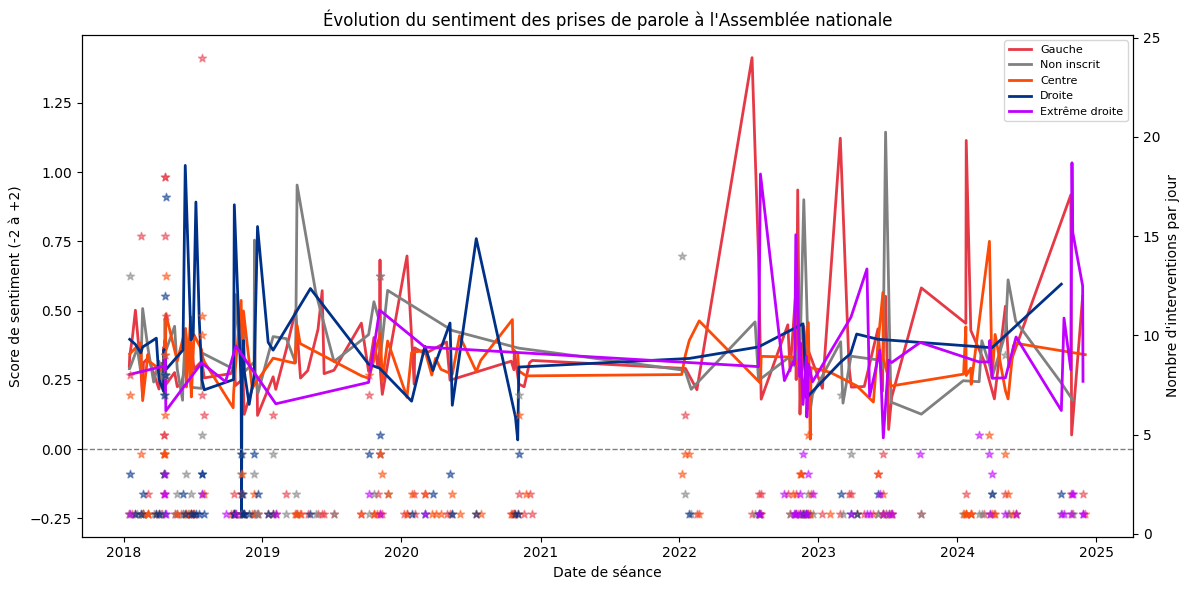

In [15]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

# Moyenne ET count par date et groupe politique
daily_per_group = (
    df.groupby(["date_seance", "groupe_politique"])["sentiment_score"]
    .agg(mean="mean", count="count")
    .reset_index()
)
for gp in daily_per_group["groupe_politique"].unique():
    d = daily_per_group[daily_per_group["groupe_politique"] == gp]
    line, = ax.plot(d["date_seance"], d["mean"], color=COULEURS[gp], linewidth=2, label=gp)
    ax2.scatter(d["date_seance"], d["count"], color=COULEURS[gp], marker="*", alpha=0.5)

# ligne neutre
ax.axhline(0, linestyle="--", linewidth=1, color="gray")

ax.set_xlabel("Date de séance")
ax.set_ylabel("Score de sentiment (-2 à +2)")
ax2.set_ylabel("Nombre d'interventions par jour")
ax.set_title("Évolution du sentiment des prises de parole à l'Assemblée nationale")
ax.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.show()

In [6]:
# Enlever les lignes sans date et créer une période (mois) pour agréger
df_clean = df.dropna(subset=["date_seance"]).copy()
df_clean["periode"] = df_clean["date_seance"].dt.to_period("M")

# Colonnes de sentiment
cols_sentiment = ["very_negative", "negative", "neutral", "positive", "very_positive"]
# Moyennes par période
evo = df_clean.groupby("periode", as_index=False)[cols_sentiment].mean()
evo["periode"] = evo["periode"].dt.to_timestamp()
evo

,periode,very_negative,negative,neutral,positive,very_positive
0,2018-01-01,0.029394,0.133623,0.405437,0.347729,0.083803
1,2018-02-01,0.029757,0.135163,0.403240,0.346307,0.085533
2,2018-03-01,0.030963,0.138212,0.392738,0.348162,0.089938
3,2018-04-01,0.031572,0.139814,0.393864,0.339851,0.094901
4,2018-05-01,0.031150,0.141067,0.398933,0.347983,0.080867
5,2018-06-01,0.026920,0.127775,0.398365,0.354230,0.092710
6,2018-07-01,0.030872,0.137824,0.393969,0.343425,0.093907
7,2018-08-01,0.032722,0.153456,0.406844,0.330133,0.076900
8,2018-09-01,0.023000,0.135400,0.474400,0.309800,0.057400
9,2018-10-01,0.031475,0.136042,0.390433,0.343742,0.098317


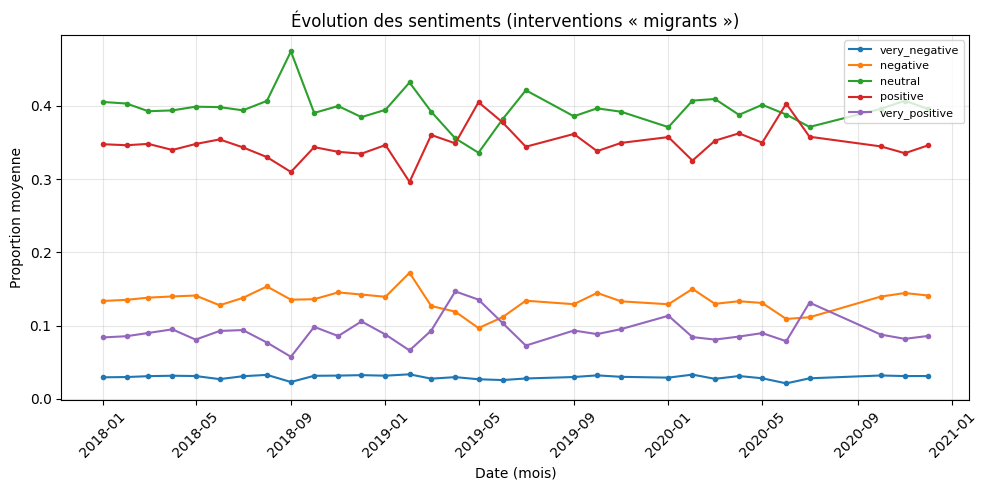

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
for col in cols_sentiment:
    ax.plot(evo["periode"], evo[col], label=col, marker="o", markersize=3)
ax.set_xlabel("Date (mois)")
ax.set_ylabel("Proportion moyenne")
ax.set_title("Évolution des sentiments (interventions « migrants »)")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Score synthétique 0–4 (moyenne pondérée) pour une lecture plus simple
evo["score"] = sum(evo[c] * i for i, c in enumerate(cols_sentiment))
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(evo["periode"], evo["score"], color="black", marker="o", markersize=4)
ax.set_xlabel("Date (mois)")
ax.set_ylabel("Score (0 = very_negative, 4 = very_positive)")
ax.set_title("Évolution du sentiment moyen (interventions « migrants »)")
ax.axhline(y=2, color="gray", linestyle="--", alpha=0.7, label="neutre")
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'cols_sentiment' is not defined

In [8]:
df = pd.read_csv("../data/deputes-historique.csv")
df.head()

,id,legislatureLast,civ,nom,prenom,villeNaissance,naissance,age,groupe,groupeAbrev,...,facebook,website,nombreMandats,experienceDepute,scoreParticipation,scoreParticipationSpecialite,scoreLoyaute,scoreMajorite,active,dateMaj
0,PA1001,14,M.,Daubresse,Marc-Philippe,Lille,1953-08-01,72,Les Républicains,LES-REP,...,NaN,NaN,3,11 ans,0.91,NaN,1.000,0.109,0,2026-02-25
1,PA1008,17,M.,David,Alain,Libourne,1949-06-02,76,Socialistes et apparentés,SOC,...,NaN,alain-david.com,3,9 ans,0.07,0.00,0.912,0.000,1,2026-02-25
2,PA1009,12,Mme,David,Martine,Loches,1952-12-19,73,Socialiste,SOC,...,NaN,NaN,1,5 ans,NaN,NaN,NaN,NaN,0,2026-02-25
3,PA1012,15,M.,de la Verpillière,Charles,Bourg-en-Bresse,1954-05-31,71,Les Républicains,LR,...,charlesdelaverpilliere,www.charlesdelaverpilliere.com,3,15 ans,0.12,0.26,0.950,0.247,0,2026-02-25
4,PA1020,14,M.,Debré,Bernard,Toulouse,1944-09-30,81,Les Républicains,LES-REP,...,NaN,www.bernarddebre.fr,3,13 ans,0.96,NaN,0.851,0.140,0,2026-02-25


In [9]:
df.columns

Index(['id', 'legislatureLast', 'civ', 'nom', 'prenom', 'villeNaissance',
       'naissance', 'age', 'groupe', 'groupeAbrev', 'departementNom',
       'departementCode', 'circo', 'datePriseFonction', 'job', 'mail',
       'twitter', 'facebook', 'website', 'nombreMandats', 'experienceDepute',
       'scoreParticipation', 'scoreParticipationSpecialite', 'scoreLoyaute',
       'scoreMajorite', 'active', 'dateMaj'],
      dtype='object')

In [2]:
len(df)

910